#### Checking the GPU (applicable if using CUDA)

In [1]:
# !nvidia-smi -L

#### Imports

In [2]:
import torch
torch.cuda.empty_cache() # clear GPU memory to avoid CUDA out of memory error

import time
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Custom local imports
from src.dataloader import get_MELD_loaders
from src.trainer import build_model, trainer

In [4]:
# To ignore the warnings from sklearn.metrics.classification_report
import warnings
warnings.filterwarnings("ignore") 

#### Prepare the arguments and data

text, audio, text + audio

In [5]:
import argparse


def parse_opt():
    parser = argparse.ArgumentParser()

    parser.add_argument('--no-cuda', action='store_true',
                        default=True, help='does not use CUDA')
    parser.add_argument('--dir', type=str, default='./MELD_features/',
                        help='dataset directory (for .pkl file)')
    parser.add_argument('--n-classes', type=int, default=7,
                        help='number of classes')
    parser.add_argument('--val-split', type=float,
                        default=0.1, help='validation split')
    parser.add_argument('--num-workers', type=int,
                        default=0, help='number of workers')

    parser.add_argument('--loss-fn', type=str, default='masked_nll',
                        help='loss function (masked_nll or unmaksed_weighted_nll or masked_mse)')
    parser.add_argument('--optimizer', type=str, default='sgd',
                        help='optimizer (adam or sgd or rmsprop)')

    parser.add_argument('--lr', type=float, default=1e-4,
                        metavar='LR', help='learning rate')
    parser.add_argument('--l2', type=float, default=3e-4,
                        metavar='L2', help='L2 regularization weight')
    parser.add_argument('--dropout', type=float, default=0.25,
                        metavar='dropout', help='dropout rate')
    parser.add_argument('--batch-size', type=int, default=20,
                        metavar='BS', help='batch size')
    parser.add_argument('--epochs', type=int, default=50,
                        metavar='E', help='number of epochs')

    parser.add_argument('--class-weight', action='store_true',
                        default=True, help='use class weights (true or false)')
    parser.add_argument('--mu', type=float, default=0,
                        help='class weight (mu)')

    parser.add_argument('--seed', type=int, default=42,
                        metavar='seed', help='seed')

    parser.add_argument('--feature_type', type=str, default='multimodal',
                        help='features (text or audio or multimodal)')
    parser.add_argument('--attention', type=str, default='general',
                        help='attention type (simple or general or general2 or concat or dot)')

    parser.add_argument('--verbose', action='store_true',
                        default=True, help='verbose (true or false)')

    args = parser.parse_args("")

    return args

In [6]:
args = parse_opt()

In [7]:
args.cuda = not args.no_cuda and torch.cuda.is_available()

#### Print the arguments to be used for model training

In [8]:
import pprint
pp = pprint.PrettyPrinter(depth=4) # PrettyPrinter is used to print the arguments in a clean way
pp.pprint(vars(args))

{'attention': 'general',
 'batch_size': 20,
 'class_weight': True,
 'cuda': False,
 'dir': './MELD_features/',
 'dropout': 0.25,
 'epochs': 50,
 'feature_type': 'multimodal',
 'l2': 0.0003,
 'loss_fn': 'masked_nll',
 'lr': 0.0001,
 'mu': 0,
 'n_classes': 7,
 'no_cuda': True,
 'num_workers': 0,
 'optimizer': 'sgd',
 'seed': 42,
 'val_split': 0.1,
 'verbose': True}


In [9]:
global D_m

if args.feature_type == 'text':
    print("Running on the text features........")
    D_m = 600
elif args.feature_type == 'audio':
    print("Running on the audio features........")
    D_m = 300
elif args.feature_type == 'multimodal':
    print("Running on the multimodal features........")
    D_m = 900
    
D_g = D_q = D_r = 150
D_h = D_e = 100

Running on the multimodal features........


#### Initialize the model and view the architecture

In [10]:
model, optimizer, loss_function = build_model(D_m, D_q, D_g, D_r, D_e, D_h, args)

EmotionNet(
  (dropout): Dropout(p=0.25, inplace=False)
  (emo_rnn_b): EmotionRNN(
    (dropout): Dropout(p=0.25, inplace=False)
    (cell): EmotionGRUCell(
      (g_cell): GRUCell(1200, 150)
      (p_cell): GRUCell(1050, 150)
      (pl_cell): GRUCell(1050, 150)
      (r_cell): GRUCell(1050, 150)
      (rl_cell): GRUCell(1050, 150)
      (e_cell): GRUCell(1200, 100)
      (dropout): Dropout(p=0.25, inplace=False)
      (attention): MatchingAttention(
        (transform): Linear(in_features=900, out_features=150, bias=False)
      )
    )
  )
  (emo_rnn_f): EmotionRNN(
    (dropout): Dropout(p=0.25, inplace=False)
    (cell): EmotionGRUCell(
      (g_cell): GRUCell(1200, 150)
      (p_cell): GRUCell(1050, 150)
      (pl_cell): GRUCell(1050, 150)
      (r_cell): GRUCell(1050, 150)
      (rl_cell): GRUCell(1050, 150)
      (e_cell): GRUCell(1200, 100)
      (dropout): Dropout(p=0.25, inplace=False)
      (attention): MatchingAttention(
        (transform): Linear(in_features=900, out_feat

#### Initialize the data loaders (train, validation, test)

In [11]:
train_loader, valid_loader , test_loader = get_MELD_loaders(path = args.dir + 'MELD_features_raw.pkl',
                                                            n_classes=args.n_classes,
                                                            valid=args.val_split,
                                                            batch_size=args.batch_size,
                                                            num_workers=args.num_workers)

#### Training phase

* Logs printing frequency: 10 iterations

In [12]:
model, metrics, best_label, best_pred, best_mask, best_attn, test_class_report = trainer(args=args, 
                                                                                         model=model, 
                                                                                         train_loader=train_loader, 
                                                                                         valid_loader=valid_loader, 
                                                                                         test_loader=test_loader, 
                                                                                         optimizer=optimizer, 
                                                                                         loss_function=loss_function)

Epoch [1]/[50]	 Train Loss: 2.435	 Train Acc: 13.290%	 Train F1: 15.420	 Val Loss: 1.928	 Val Acc: 26.890%	 Val F1: 29.790	 Test Loss: 1.929	 Test Acc: 24.140%	 Test F1: 27.890	 Time: 32.52 sec 
Epoch [10]/[50]	 Train Loss: 2.047	 Train Acc: 26.170%	 Train F1: 31.360	 Val Loss: 1.738	 Val Acc: 59.380%	 Val F1: 60.220	 Test Loss: 1.762	 Test Acc: 47.700%	 Test F1: 48.530	 Time: 26.48 sec 


In [ ]:
train_losses = metrics['train']['train_losses']
train_fscores = metrics['train']['train_fscores']
train_accs = metrics['train']['train_accs']

val_losses = metrics['val']['val_losses']
val_fscores = metrics['val']['val_fscores']
val_accs = metrics['val']['val_accs']

test_losses = metrics['test']['test_losses']
test_fscores = metrics['test']['test_fscores']
test_accs = metrics['test']['test_accs']

best_fscore = metrics['best']['best_fscore']
best_loss = metrics['best']['best_loss']
best_acc = metrics['best']['best_acc']

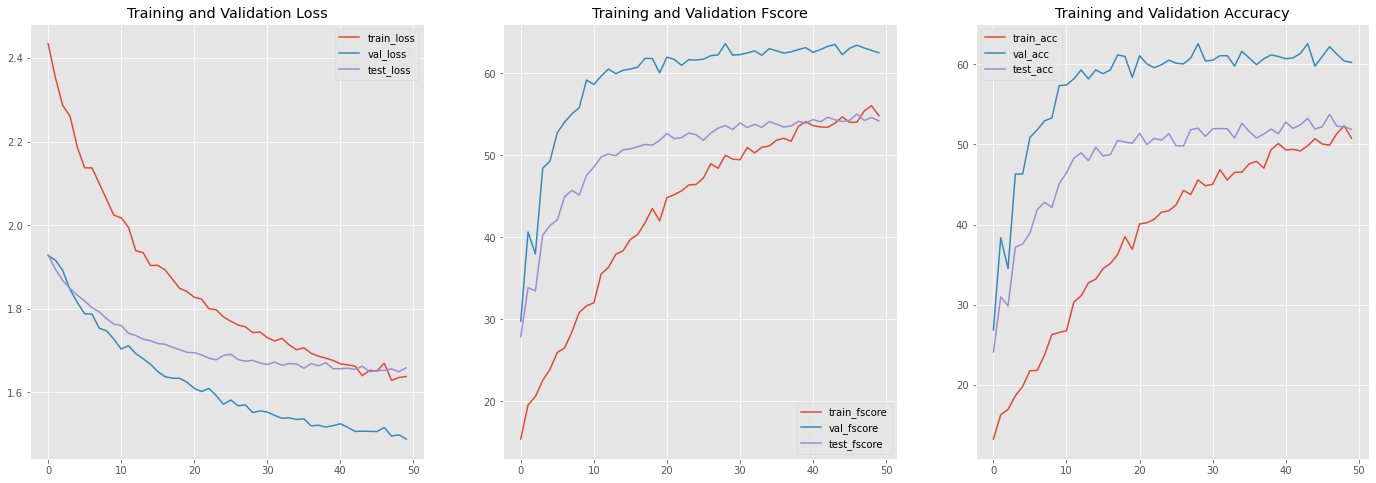

In [ ]:
# plot the training and validation loss and accuracy
plt.style.use("ggplot")

fig = plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.plot(test_losses, label='test_loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_fscores, label='train_fscore')
plt.plot(val_fscores, label='val_fscore')
plt.plot(test_fscores, label='test_fscore')
plt.title('Training and Validation Fscore')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accs, label='train_acc')
plt.plot(val_accs, label='val_acc')
plt.plot(test_accs, label='test_acc')
plt.title('Training and Validation Accuracy')
plt.legend()

#### Testing phase

In [ ]:
print('[Metrics]')
print('Fscore: {:.3f}\tLoss: {:.3f}\tAccuracy: {:.3f}%\n'.format(best_fscore, best_loss, accuracy_score(best_label,best_pred,sample_weight=best_mask)*100))

[Metrics]
Fscore: 55.050	Loss: 1.653	Accuracy: 53.755%



In [ ]:
print('[Classification report]:\n')
print(classification_report(best_label,best_pred,sample_weight=best_mask,digits=4))

[Classification report]:

              precision    recall  f1-score   support

           0     0.7561    0.6688    0.7098    1256.0
           1     0.4719    0.5089    0.4897     281.0
           2     0.0000    0.0000    0.0000      50.0
           3     0.2826    0.2500    0.2653     208.0
           4     0.5704    0.4129    0.4791     402.0
           5     0.0486    0.1029    0.0660      68.0
           6     0.3743    0.5652    0.4503     345.0

    accuracy                         0.5375    2610.0
   macro avg     0.3577    0.3584    0.3515    2610.0
weighted avg     0.5758    0.5375    0.5505    2610.0



In [ ]:
print('[Confusion matrix]:\n')
print(confusion_matrix(best_label,best_pred,sample_weight=best_mask))

[Confusion matrix]:

[[840.  62.  24.  80.  65.  77. 108.]
 [ 37. 143.   5.   7.  20.  16.  53.]
 [ 17.   4.   0.  11.   7.   2.   9.]
 [ 70.  13.   9.  52.   6.  13.  45.]
 [ 80.  39.   7.   9. 166.  14.  87.]
 [ 21.   9.   1.   4.   2.   7.  24.]
 [ 46.  33.  10.  21.  25.  15. 195.]]


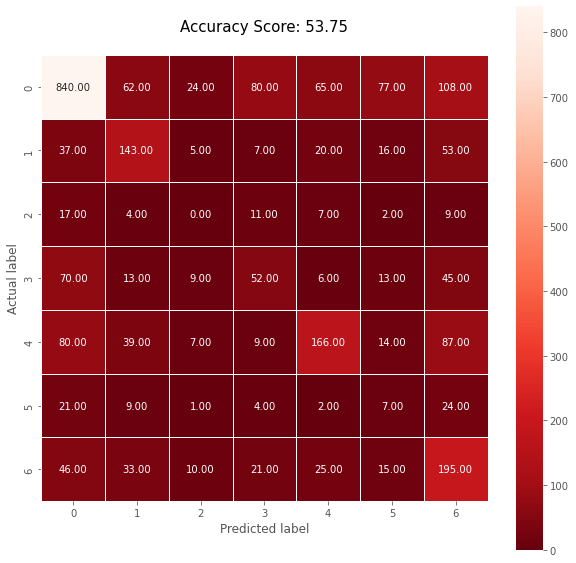

In [ ]:
### View the confusion matrix as an image
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(best_label,best_pred, sample_weight=best_mask), annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'Reds_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}\n'.format(round(accuracy_score(best_label,best_pred,sample_weight=best_mask)*100, 2))
plt.title(all_sample_title, size = 15)
plt.show()

In [ ]:
## Save the model
torch.save(model.state_dict(), 'model_v2.pt')
print(f'Saved the model to model.pt')

Saved the model to model.pt
